In [1]:
import os
import re
import math
from pathlib import Path
import itertools

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
from torchvision import transforms
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class Dataset(Dataset):
    def __init__(self, path_A, path_B, img_size=(128, 128)):
        self.to_tensor = transforms.Compose([
                                transforms.Resize(img_size), 
                                transforms.ToTensor()])
        self.re_number = re.compile('[0-9]')
        self.files_A = self._get_files_path(path_A)
        self.files_B = self._get_files_path(path_B)
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, idx):
        A = self.to_tensor(Image.open(self.files_A[idx]))
        B = self.to_tensor(Image.open(self.files_B[idx]))
        return A, B
    
    def _file_numbers(self, x):
        filename = x.stem
        file_number = int(''.join(self.re_number.findall(filename)))
        return file_number
    
    def _get_files_path(self, directory):
        path_files = directory.glob('*')
        path_files = sorted(path_files, key=self._file_numbers)
        return path_files

In [5]:
train_path_A = Path('data/monet2photo/trainA')
train_path_B = Path('data/monet2photo/trainB')
val_path_A = Path('data/monet2photo/testA')
val_path_B = Path('data/monet2photo/testB')
dir_generated_X = Path('data/monet2photo/fake_X')
dir_generated_Y = Path('data/monet2photo/fake_Y')

In [6]:
train_dataset = Dataset(train_path_A, train_path_B)
val_dataset = Dataset(val_path_A, val_path_B)

<center> Utils

In [31]:
def save_pics(fake, real, 
              epoch: int, batch_idx: int, 
              dir_generated):
    path_fake = dir_generated.joinpath(f'fake_{epoch}_{batch_idx}.png')
    path_real = dir_generated.joinpath(f'real_{epoch}_{batch_idx}.png')
    # saving
    torchvision.utils.save_image(fake.data, 
                                 path_fake, 
                                 normalize=True)
    torchvision.utils.save_image(real.data, 
                                 path_real, 
                                 normalize=True)

In [38]:
def watch_generations(dataset, G_x, G_y, dir_generated_X, dir_generated_Y):
    # get random index 
    ind = np.random.randint(len(dataset))
    # generate
    with torch.no_grad():
        G_x.eval(), G_y.eval()
        x_real, y_real = dataset[ind]
        x_real, y_real = x_real.unsqueeze(0), y_real.unsqueeze(0)
        y_fake = G_x(x_real.to(device)).cpu()
        x_fake = G_y(y_real.to(device)).cpu()
    
    # saving pictures
    save_pics(y_fake, x_real,
              epoch=epoch, batch_idx=batch_idx, 
              dir_generated=dir_generated_X)
    save_pics(x_fake, y_real,
              epoch=epoch, batch_idx=batch_idx, 
              dir_generated=dir_generated_Y)

In [9]:
def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean=0.0, std=0.02)

<center> Generator Layers

In [10]:
class DKLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DKLayer, self).__init__()
        self.refl_padding = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=0)
        self.instance_norm = nn.InstanceNorm2d(out_channels)
        
    def forward(self, batch):
        batch = self.refl_padding(batch)
        batch = self.conv(batch)
        batch = self.instance_norm(batch)
        batch = F.relu(batch)
        return batch

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResidualBlock, self).__init__()
        self.refl_padding_1 = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=0)
        self.refl_padding_2 = nn.ReflectionPad2d(1)
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=0)
        
    def forward(self, batch):
        padded_batch = self.refl_padding_1(batch)
        conv_batch = self.conv1(padded_batch)
        padded_batch = self.refl_padding_2(conv_batch)
        conv_batch = self.conv2(padded_batch)
        out = batch + conv_batch
        return out

In [12]:
class Generator(nn.Module):
    def __init__(self, num_res=6):
        super(Generator, self).__init__()
        self.num_res = num_res
        #make layers
        self.refl_padding_1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=0)
        self.instance_norm1 = nn.InstanceNorm2d(32)
        self.dk_layer_1 = DKLayer(32, 64)
        self.dk_layer_2 = DKLayer(64, 128)
        self.res_blocks = nn.ModuleList([ResidualBlock(128) for _ in range(num_res)])
        
        self.conv_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=3, 
                                               stride=2, padding=1, 
                                               output_padding=1)
        self.instance_norm2 = nn.InstanceNorm2d(64)
        self.conv_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=3, 
                                               stride=2, padding=1, 
                                               output_padding=1)
        self.instance_norm3 = nn.InstanceNorm2d(32)
        
        self.refl_padding_2 = nn.ReflectionPad2d(3)
        self.conv2 = nn.Conv2d(32, 3, kernel_size=7, stride=1, padding=0)
        #init weights
        self.apply(weights_init)
        
    def forward(self, batch):
        #print('IN', batch.shape)
        batch = self.refl_padding_1(batch)
        batch = self.conv1(batch)
        batch = self.instance_norm1(batch)
        batch = F.relu(batch)
        #print('R', batch.shape)
        batch = self.dk_layer_1(batch)
        #print('DK1', batch.shape)
        batch = self.dk_layer_2(batch)
        #print('DK2', batch.shape)
        #res blocks
        for i in range(self.num_res):
            batch = self.res_blocks[i](batch)
        #print('RES', batch.shape)
        #deconvolutions
        batch = self.conv_trans_1(batch)
        batch = self.instance_norm2(batch)
        batch = F.relu(batch)
        #print('DEC1', batch.shape)
        batch = self.conv_trans_2(batch)
        batch = self.instance_norm3(batch)
        batch = F.relu(batch)
        #print('DEC2', batch.shape)
        batch = self.refl_padding_2(batch)
        batch = self.conv2(batch)
        batch = torch.tanh(batch)
        return batch

<center> Discriminator Layers

In [13]:
class ConvolutionNorm(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(ConvolutionNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, stride=stride, 
                              kernel_size=4, padding=1)
        self.instance_norm = nn.InstanceNorm2d(out_channels)
        
    def forward(self, batch, use_norm=True):
        batch = self.conv(batch)
        if use_norm:
            batch = self.instance_norm(batch)
        batch = F.leaky_relu(batch, 0.2)
        return batch

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = ConvolutionNorm(3, 64)
        self.conv2 = ConvolutionNorm(64, 128)
        self.conv3 = ConvolutionNorm(128, 256)
        self.conv4 = ConvolutionNorm(256, 512, stride=1)
        self.conv_out = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        self.apply(weights_init)
        
    def forward(self, batch):
        batch = self.conv1(batch, use_norm=False)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        outputs = self.conv4(batch)
        logits = self.conv_out(outputs)
        #logits = logits.squeeze(3).squeeze(2)
        probs = torch.sigmoid(logits)#.squeeze()
        return probs

<center> Loss Functions

In [15]:
#def cycle_loss(generator_x, generator_y, x, y):
#     fake_x = generator_x(y)
#     fake_y = generator_y(x)
#     proxy_y  = generator_y(fake_x)
#     proxy_x = generator_x(fake_y)
#     loss = (proxy_y - y).mean() + (proxy_x - x).mean()
#     return loss

In [16]:
cycle_loss = torch.nn.L1Loss()
mse_criterion = nn.MSELoss()

In [17]:
def discriminator_loss(discriminator, real_input, fake_input):
    prob_real = discriminator(real_input)
    real = torch.ones_like(prob_real).to(prob_real.device)
    prob_fake = discriminator(fake_input)
    fake = torch.zeros_like(prob_fake).to(prob_fake.device)
    
    real_loss = mse_criterion(prob_real, real)
    fake_loss = mse_criterion(prob_fake, fake)
    loss = (real_loss + fake_loss) / 2
    return loss

In [18]:
def generator_gan_loss(discriminator, fake_input):
    prob_fake = discriminator(fake_input)
    real = torch.ones_like(prob_fake).to(prob_fake.device)
    loss = mse_criterion(prob_fake, real)
    return loss

In [19]:
def generator_total_loss(x, y,
                         fake_x, fake_y, 
                         rec_x, rec_y, 
                         D_x, D_y, lambda_coef: float = 10):
    # GAN losses
    gen_loss_x = generator_gan_loss(D_y, fake_x)
    gen_loss_y = generator_gan_loss(D_x, fake_y)
    # Cycle loss
    c_loss_x = cycle_loss(rec_x, x)
    c_loss_y = cycle_loss(rec_y, y)
    # total loss
    loss = gen_loss_x + gen_loss_y + lambda_coef * (c_loss_x + c_loss_y)
    return loss

<center> Training

In [20]:
def one_step(D_x, D_y, G_x, G_y, x, y, pass_steps=50, lambda_coef=10):
    G_x.train(), G_y.train()
    # Generators steps
    for _ in range(pass_steps):
        fake_x = G_y(y)
        fake_y = G_x(x)
        rec_x = G_y(fake_y)
        rec_y = G_x(fake_x)
        # compute generator loss
        gen_loss = generator_total_loss(x, y,
                                        fake_x, fake_y, 
                                        rec_x, rec_y,
                                        D_x, D_y, 
                                        lambda_coef=lambda_coef)
        optimizer_G.zero_grad()
        gen_loss.backward()
        optimizer_G.step()
        
    # Discriminators step
    dis_y = discriminator_loss(D_y, y, fake_x.detach())
    dis_x = discriminator_loss(D_x, x, fake_y.detach())
    optimizer_D.zero_grad()
    dis_x.backward()
    dis_y.backward()
    optimizer_D.step()

In [40]:
num_epochs = 200
batch_size = 1
lr = 0.0002

In [22]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=6)

In [23]:
D_x = Discriminator().to(device)
D_y = Discriminator().to(device)
G_x = Generator().to(device)
G_y = Generator().to(device)

In [24]:
optimizer_G = torch.optim.Adam(itertools.chain(G_x.parameters(), G_y.parameters()),
                               lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_x.parameters(), D_y.parameters()),
                               lr=lr, betas=(0.5, 0.999))

In [45]:
scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, 
                                                lr_lambda=lambda epoch: 0.99 ** epoch)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, 
                                                lr_lambda=lambda epoch: 0.99 ** epoch)

In [25]:
for X_batch, Y_batch in val_dataloader:
    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) 
    break

In [33]:
epoch = 17
models_dir = Path('models/')

In [47]:
epoch

51

In [48]:
%%time
while epoch <= num_epochs:
    for batch_idx, (X_batch, Y_batch) in enumerate(train_dataloader):
        # optimize
        one_step(D_x, D_y, G_x, G_y, 
                 X_batch.to(device), 
                 Y_batch.to(device), pass_steps=5)
        # save fake, real
        if batch_idx % 100 == 0:
            print(f'{epoch}_{batch_idx}: pic saved')
            watch_generations(val_dataset, G_x, G_y, 
                              dir_generated_X, dir_generated_Y)
    
    # saving model
    torch.save(G_x, models_dir.joinpath(f'GX_{epoch}'))
    torch.save(G_y, models_dir.joinpath(f'GY_{epoch}'))
    torch.save(D_x, models_dir.joinpath(f'DX_{epoch}'))
    torch.save(D_y, models_dir.joinpath(f'DY_{epoch}'))
    
    #make step
    if epoch >= 100:
        scheduler_G.step()
        scheduler_D.step()
        
    epoch += 1

51_0: pic saved
51_100: pic saved
51_200: pic saved
51_300: pic saved
51_400: pic saved
51_500: pic saved
51_600: pic saved
51_700: pic saved
51_800: pic saved
51_900: pic saved
51_1000: pic saved
52_0: pic saved
52_100: pic saved
52_200: pic saved
52_300: pic saved
52_400: pic saved
52_500: pic saved
52_600: pic saved
52_700: pic saved
52_800: pic saved
52_900: pic saved
52_1000: pic saved
53_0: pic saved
53_100: pic saved
53_200: pic saved
53_300: pic saved
53_400: pic saved
53_500: pic saved
53_600: pic saved
53_700: pic saved
53_800: pic saved
53_900: pic saved
53_1000: pic saved
54_0: pic saved
54_100: pic saved
54_200: pic saved
54_300: pic saved
54_400: pic saved
54_500: pic saved
54_600: pic saved
54_700: pic saved
54_800: pic saved
54_900: pic saved
54_1000: pic saved
55_0: pic saved
55_100: pic saved
55_200: pic saved
55_300: pic saved
55_400: pic saved
55_500: pic saved
55_600: pic saved
55_700: pic saved
55_800: pic saved
55_900: pic saved
55_1000: pic saved
56_0: pic saved

KeyboardInterrupt: 

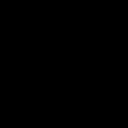

In [50]:
Image.open('data/monet2photo/fake_X/fake_90_800.png')